In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.options.display.max_columns = 99

In [2]:
os.chdir('..')  # change to root directory

In [3]:
# Load data
import pickle
from firenet.util import add_uncertainty_features
with open('./data/d_data.pkl', 'rb') as infile:
    d_data = pickle.load(infile)
    
d_data = add_uncertainty_features(d_data)
d_data.keys()

dict_keys(['fullbay', 'fullbayerr', 'shortbay', 'shortbayerr', 'redshift', 'observed', 'observederr', 'obserr_to_short', 'obs_to_short'])

# Single train/test split

In [4]:
from firenet.ml.reguncpredictor import RegUncPredictor

pred = RegUncPredictor(d_data)
pred.preprocess()
pred.train_regressor()

  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1        0.8499        0.6397     +  0.0753
      2        0.5569        0.3938     +  0.0798
      3        0.3919        0.3158     +  0.0755
      4        0.3326        0.2815     +  0.0796
      5        0.3061        0.2620     +  0.0911
      6        0.2856        0.2474     +  0.1049
      7        0.2684        0.2360     +  0.0776
      8        0.2547        0.2271     +  0.0804
      9        0.2440        0.2200     +  0.0776
     10        0.2356        0.2146     +  0.0870
     11        0.2289        0.2106     +  0.0840
     12        0.2233        0.2077     +  0.0770
     13        0.2185        0.2054     +  0.0863
     14        0.2144        0.2037     +  0.0819
     15        0.2109        0.2021     +  0.0874
     16        0.2078        0.2004     +  0.0833
     17        0.2050        0.1991     +  0.0793
     18        0.2026        0.1976     +  0.0851


In [5]:
pred.train_uncertainty()

  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1      217.9696      -50.8238     +  0.0883
      2     -410.5300     -835.7412     +  0.0848
      3    -1313.6208    -1661.0611     +  0.0833
      4    -2082.1282    -2191.2182     +  0.1440
      5    -2547.8788    -2468.2852     +  0.1374
      6    -2800.5977    -2605.5371     +  0.1631
      7    -2937.2097    -2675.5470     +  0.1396
      8    -3015.6655    -2714.8626     +  0.1358
      9    -3065.2980    -2740.2857     +  0.1115
     10    -3099.7257    -2758.3369     +  0.0848
     11    -3125.1543    -2771.9867     +  0.0800
     12    -3144.9273    -2782.5384     +  0.0941
     13    -3160.9275    -2790.9683     +  0.1448
     14    -3174.1579    -2797.7806     +  0.0912
     15    -3185.2531    -2803.3262     +  0.0753
     16    -3194.6717    -2808.0326     +  0.1148
     17    -3202.7446    -2811.9943     +  0.1479
     18    -3209.7866    -2815.4636     +  0.1297


In [6]:
pred.reg.test()

PACS_70      0.217630
PACS_100     0.191416
PACS_160     0.174848
SPIRE_250    0.187485
SPIRE_350    0.202813
SPIRE_500    0.215696
Name: rmse, dtype: float64

In [7]:
pred.unc.test()

PACS_70      1.100971
PACS_100     1.148913
PACS_160     1.207514
SPIRE_250    1.079786
SPIRE_350    1.020826
SPIRE_500    0.986772
Name: mean_chisq, dtype: float64

In [8]:
y_t, y_p, y_perr = pred.get_target_set()

In [9]:
# Storing and loading models
from firenet.ml.modelstore import ModelStore

ModelStore().store(pred, name='nnet')  # Save to './models/nnet.pkl' by default
pred = ModelStore().load(d_data, name='nnet')  # Load "nnet" model

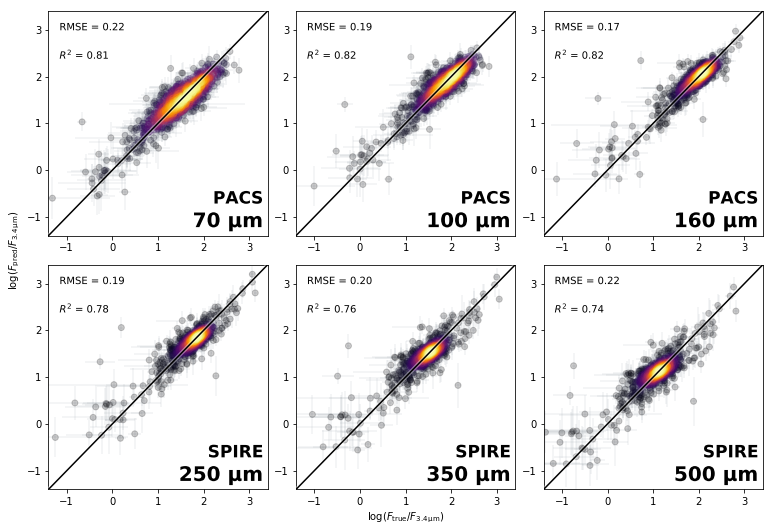

In [10]:
from firenet.plotting.truevspred import TrueVSPredPlotter

firbands = d_data['fullbay'].columns[-6:]
idx = y_t.index
y_terr = d_data['fullbayerr'].loc[idx, firbands].divide(d_data['fullbay'].loc[idx] * np.log(10), axis=0)

tvpplot = TrueVSPredPlotter(figsize=(12.8, 8.8))
tvpplot.create_panels(nrows=1)
panel = tvpplot.get_panel(0)
panel.stylized_plot(y_t, y_p, y_terr=y_terr, y_perr=y_perr, 
                    style='firflux')

# Full set predictor
Using a 4-fold train/test split, training 4 predictors. Each galaxy is used as a test sample once.

In [11]:
from firenet.ml.fullsetpredictor import FullSetPredictor
fspred = FullSetPredictor(d_data)

In [12]:
fspred.prepare_splits(shuffle_state=123)

In [13]:
fspred.train()

Start training model 1/4...
Start training model 2/4...
Start training model 3/4...
Start training model 4/4...


In [14]:
# Storing and loading models
from firenet.ml.modelstore import ModelStore

ModelStore().store(fspred, name='fsnnet')  # Save to './models/fsnnet.pkl' by default
fspred = ModelStore().load(d_data, name='fsnnet')  # Load "fsnnet" model

In [15]:
y_t, y_p, y_perr = fspred.get_combined_test()

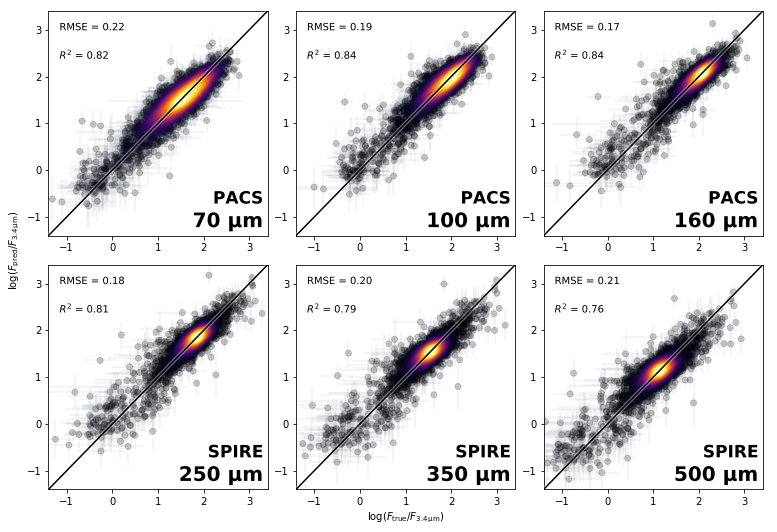

In [16]:
# See paper Fig. 3
from firenet.plotting.truevspred import TrueVSPredPlotter

firbands = d_data['fullbay'].columns[-6:]
idx = y_t.index
y_terr = d_data['fullbayerr'].loc[idx, firbands].divide(d_data['fullbay'].loc[idx] * np.log(10), axis=0)

tvpplot = TrueVSPredPlotter(figsize=(12.8, 8.8))
tvpplot.create_panels(nrows=1)
panel = tvpplot.get_panel(0)
panel.stylized_plot(y_t, y_p, y_terr=y_terr, y_perr=y_perr, 
                    style='firflux')